<!-- ## update this TOC -->
1. [**Image Processing**](#img_proc)

    b. [**Extract color channels**](#ext_color_chan)
    
    a. [**Median image subtraction**](#med_img_sub)
    
2. [**Track processed frames**](#tracking)
3. [**Data filtering**](#data_filtering)
4. [**Trajectory analysis**](#traj_analysis)
5. [**Plotting**](#plotting)

    a. [**Positions**](#positions)
    
    b. [**Velocities**](#velocities)
    
    c. [**Accelerations**](#accelerations)
6. [**Postcards**](#postcards)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import pims
from pims import ImageSequence
from pims import pipeline
import trackpy as tp
import glob

import tracking_tools as track_tools

import time
import os

In [83]:
## See link below for many details about font sizes on a matplotlib figure 
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

## Figure aesthetics
# plt.rcParams.update(plt.rcParamsDefault) # resets to default values
# plt.rcParams.update({'figure.facecolor': 'none'}) # sets figure backgroud to transparent 

fs=14; fst=11 # default size value = 10
# plt.rcParams.update({'font.size': 10}) # all fonts, default
plt.rcParams.update({'axes.labelsize': fs})    # fontsize of the axes labels
plt.rcParams.update({'xtick.labelsize': fst})    # fontsize of the xtick labels
plt.rcParams.update({'ytick.labelsize': fst})    # fontsize of the ytick labels

# plt.rcParams.keys() # displays all dictionary keys and values in rcParams

In [5]:
## Experiment values (2022)
marble_diam = 3.5 # cm 
framerate = 1000.11 # Hz 

In [6]:
## Import frames into PIMS imagesequence object
path = '/vid06_tiffs/*.tiff'
frames = ImageSequence(path)
frames

output_dir = 'trackpy_output/vid06_xz_multi/'
fname_end = '_vid06_xz_multi'

In [7]:
## Make directory to store frames
if not os.path.exists(output_dir): # if not exits
    os.makedirs(output_dir) # make directory

In [8]:
## Get values for image shape
nf,ny,nx,nc = np.shape(frames)
print(nf,ny,nx,nc)

502 1080 1920 3


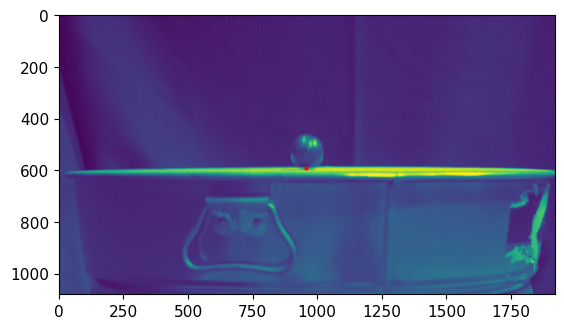

In [9]:
## Get center of impact coordinates for new origin 
xc = 955; yc = 590
t0_frame = 117

fig,ax = plt.subplots(1,1,dpi=100) 
ax.scatter(xc,yc,c='r',s=4)
ax.imshow(frames[t0_frame][:,:,2]) 

pixel scaling: 37.14 px/cm


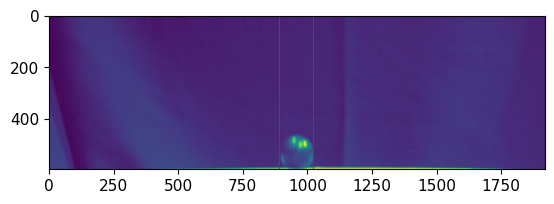

In [10]:
## Pxscale for movie frames
y1 = 890
y2 = 1020
pxscale = track_tools.get_pixel_scale(frames[t0_frame][:595,:,2], y1, y2, nx, marble_diam, 'v', 'cm')

# Image Processing
<a id='img_proc'></a>

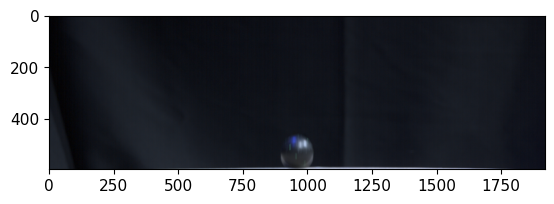

In [11]:
## Crop frames...
bcrop = 595 # amount to crop bottom of frames 
cframes = track_tools.crop_frames(frames, bcrop=bcrop)
plt.imshow(cframes[t0_frame]) 

In [12]:
## Set extent of image in physical units (for imshow calls) 
img_extent = [-xc/pxscale, (nx-xc)/pxscale, (yc-bcrop)/pxscale, yc/pxscale] # w/ cropping
img_extent

[-25.71153846153846,
 25.98076923076923,
 -0.1346153846153846,
 15.884615384615383]

### Extract color channels
<a id='ext_color_chan'></a>

In [ ]:
## Extract color channels
rframes = track_tools.extract_single_color(cframes,0) # red channel
gframes = track_tools.extract_single_color(cframes,1) # green channel
bframes = track_tools.extract_single_color(cframes,2) # blue channel

bframes # dispay information

Text(0.5, 1.0, 'blue')

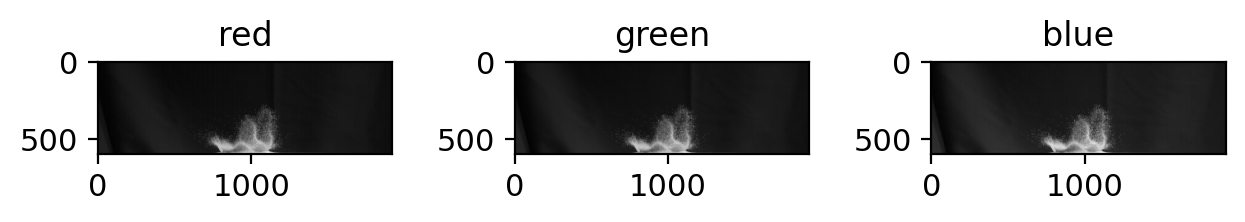

In [14]:
## Display the 3 color channels 
ii = 150
fig,ax = plt.subplots(1,3,dpi=200)
fig.tight_layout(h_pad=1)
ax[0].imshow(rframes[ii],'gray')
ax[0].set_title('red')
ax[1].imshow(gframes[ii],'gray')
ax[1].set_title('green')
ax[2].imshow(bframes[ii],'gray')
ax[2].set_title('blue')

### Median image subtraction
<a id='med_img_sub'></a>

In [15]:
## Median image parameters 
idxx = 500
diff = 100 # distance between images used for median
end_med = 200 # last frame to be used as median

In [16]:
## Make a median image 
bmedianim = track_tools.make_median(bframes[:end_med],0,diff) 
rmedianim = track_tools.make_median(rframes[:end_med],0,diff) 
gmedianim = track_tools.make_median(gframes[:end_med],0,diff) 

## Substract median image from all frames 
sbproc = track_tools.subtract_median(bframes,bmedianim)
srproc = track_tools.subtract_median(rframes,rmedianim)
sgproc = track_tools.subtract_median(gframes,gmedianim)

#plt.imshow(abproc[idxx])

Text(0.5, 1.0, 'green proc')

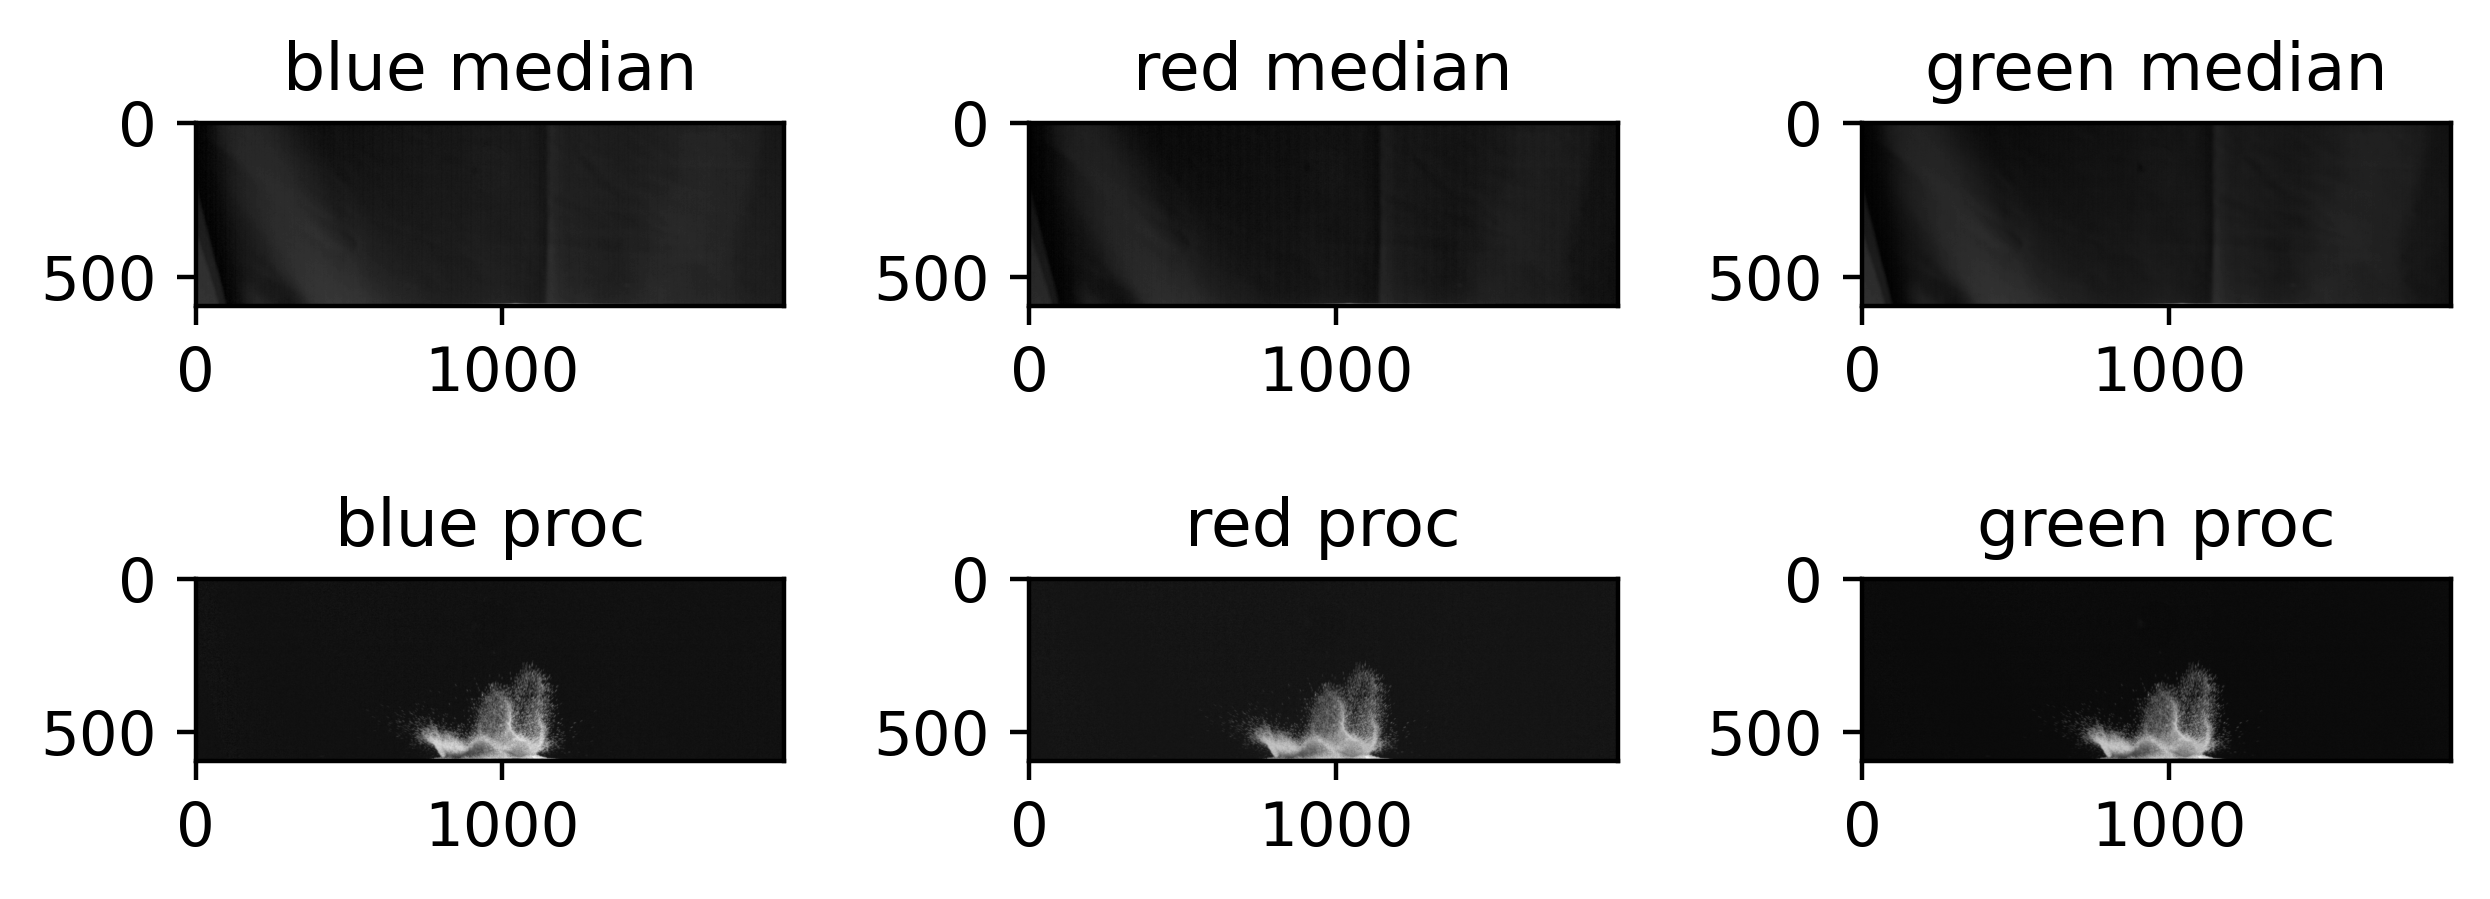

In [17]:
## Plot 3 color channels median subtract results
idx = 150
fig,ax = plt.subplots(2,3,dpi=400) 
fig.tight_layout(h_pad=-16)

ax[0,0].imshow(bmedianim,'gray')
ax[0,0].set_title('blue median') 
ax[1,0].imshow(sbproc[idx],'gray')
ax[1,0].set_title('blue proc') 
ax[0,1].imshow(rmedianim,'gray')
ax[0,1].set_title('red median') 
ax[1,1].imshow(srproc[idx],'gray')
ax[1,1].set_title('red proc') 
ax[0,2].imshow(gmedianim,'gray')
ax[0,2].set_title('green median') 
ax[1,2].imshow(sgproc[idx],'gray')
ax[1,2].set_title('green proc') 

# Track processed frames 
<a id='tracking'></a>

In [18]:
## Choose frames to perform tracking 
chosen_img = sbproc
# chosen_img = blue

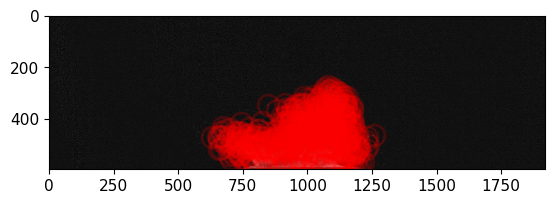

<Axes: >

In [19]:
## Identify features in a single frame 
jj = 150
rrad = 5
minmass = 40

track_pts = tp.locate(chosen_img[jj][:,:], rrad, invert=False, minmass=minmass) 
tp.annotate(track_pts, chosen_img[jj][:,:], plot_style={'alpha':0.2}) 

In [20]:
## Track and link identified features 
maxdist = 5  # max distance between frames for linking 
memory = 0 # how many frames trajectory can go missing in linking 
stublength = 10  # remove short tracks 
f0 = t0_frame - 5 # first frame 

df_traj_tracks = track_tools.track_predict(chosen_img, f0, rrad, minmass, maxdist, memory) # tracking dataframe
df_traj = tp.filter_stubs(df_traj_tracks, stublength) # filter short stubs 
print('Before:', df_traj_tracks['particle'].nunique())
print('After:', df_traj['particle'].nunique())
print(' minmass=%i,\n rrad=%i,\n maxdist=%i,\n memory=%i,\n stublength=%i' \
      %(minmass,rrad,maxdist,memory,stublength))

/Users/anaconda3/lib/python3.11/site-packages/trackpy/feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "
/Users/anaconda3/lib/python3.11/site-packages/trackpy/predict.py:227: UserWarning: Could not generate velocity field for prediction: no tracks
  warn('Could not generate velocity field for prediction: no tracks')
/Users/anaconda3/lib/python3.11/site-packages/trackpy/predict.py:227: UserWarning: Could not generate velocity field for prediction: no tracks
  warn('Could not generate velocity field for prediction: no tracks')
/Users/anaconda3/lib/python3.11/site-packages/trackpy/predict.py:227: UserWarning: Could not generate velocity field for prediction: no tracks
  warn('Could not generate

Before: 89941
After: 14229
 minmass=40,
 rrad=5,
 maxdist=5,
 memory=0,
 stublength=10


 minmass=40,
 rrad=5,
 maxdist=5,
 memory=0,
 stublength=10


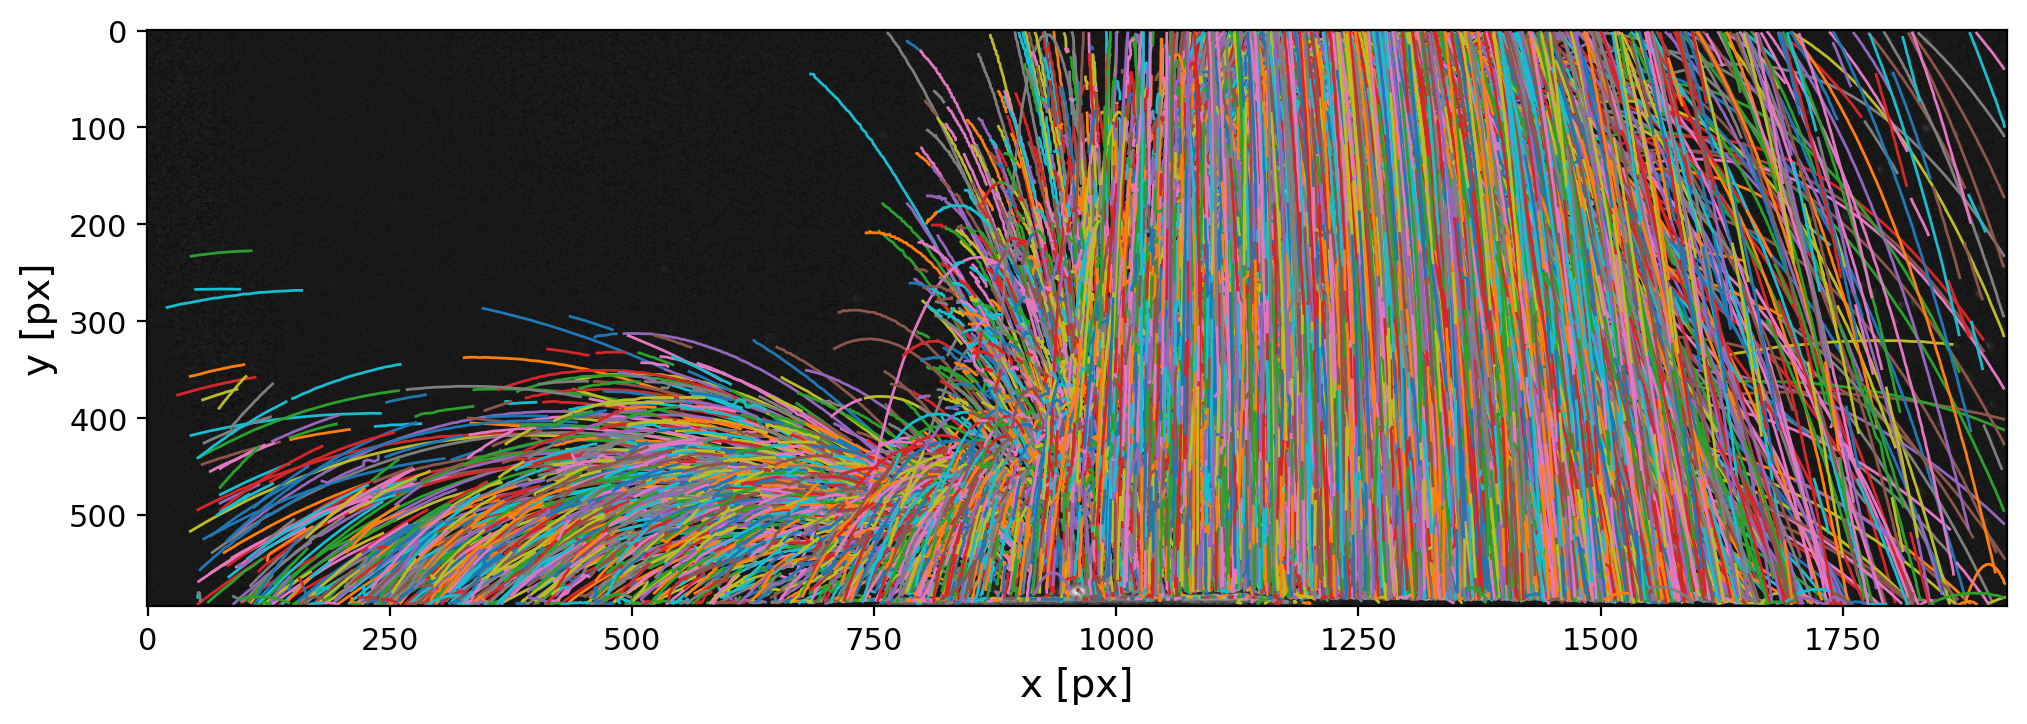

Text(0.5, 1.0, 'trackpy result')

In [21]:
## Print parameters used in tracking for documenting which values generated the displayed tracks 
print(' minmass=%i,\n rrad=%i,\n maxdist=%i,\n memory=%i,\n stublength=%i' \
      %(minmass,rrad,maxdist,memory,stublength))

plt.figure(figsize=(12,4),dpi=200) 
ax = tp.plot_traj(df_traj, superimpose=chosen_img[450])  # all tracks found

## These commands are for adjusting the number axis major tick marks when font size is larger
## changes only show when figure is saved, not when rendered in jupyter notebook
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
ax.yaxis.set_major_locator(plt.MultipleLocator(100)) # y-axis tick format 
ax.set_title('trackpy result')

# ax.figure.savefig('sb_traj.png', dpi=400, bbox_inches='tight') 

### More rigorous filtering of trajectories
<a id='data_filtering'></a>

In [22]:
# dr_min = 2
# dR_thresh = 10
# dfa_traj_filt = track_tools.filter_trajectories(df_traj, dr_min, dR_thresh, stublength, dr_max=1000.0)

In [23]:
# # Print parameters used in tracking for documenting which values generated the displayed tracks 
# print(' minmass=%i,\n rrad=%i,\n maxdist=%i,\n memory=%i,\n stublength=%i' \
#       %(minmass,rrad,maxdist,memory,stublength))

# plt.figure(figsize=(12,4),dpi=200) 
# ax = tp.plot_traj(df_traj_filt, superimpose=bframes[450])  # all tracks found

# ## These commands are for adjusting the number axis major tick marks when font size is larger
# ## changes only show when figure is saved, not when rendered in jupyter notebook
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
# ax.yaxis.set_major_locator(plt.MultipleLocator(100))

# fig_width, fig_height = plt.gcf().get_size_inches()
# # print(fig_width, fig_height)
# # ax.figure.savefig('sb_traj.png', dpi=400, bbox_inches='tight') 

In [24]:
# def plot_filtered_traj(df_traj, df_traj_filt, img, xscale=1., yscale=1., units_label='px', save=False, savepath=''):
# # def plot_traj_comparison():
#     '''
#     Plots the originally tracked trajectories and filtered trajectories alongside each other against a background frame.

#     Parameters:
#     -----------
#     df_traj : DataFrame
#         DataFrame of originally tracked trajectories
#     df_traj_filt : DataFrame
#         Dataframe of filtered time series trajectory information based on conditions
#     img : ndarray
#         Background image frame
#     xscale : float
#         Pixel-to-um conversion factor for the horizontal coordinate; default = 1.0
#     yscale : float
#         Pixel-to-um conversion factor for the vertical coordinate; default = 1.0
#     units_label : str
#         Units in the image to be displayed in the figure axes labels; default 'px' (pixels)
#     save : bool
#         Flag to save figure. Defalut False
#     savepath : str
#         Location on disk to save image

#     Returns:
#     --------
#     Nothing
#     '''
#     # # Clear the previous plot
#     # ax.clear()

#     # # Get user inputs and nescessary variables 
#     # idx = int(entry_idx.get()) 
#     # df_traj = trajectories.copy() 
#     # df_traj_filt = trajectories_filtered.copy() 

#     fsize=10
#     alpha=0.5
#     fig,ax=plt.subplots(1,1)
#     ax.set_title('Trajectories (filtered)', fontsize=fsize)
#     ax.set_xlabel('x [px]') #[%s]' %units_label)
#     ax.set_ylabel('y [px]') #[%s]' %units_label)

#     ax.imshow(img, 'gray', extent=[0, nx, 0, ny])

#     pid = np.unique(df_traj.particle) 
#     pid_filt = np.unique(df_traj_filt.particle) 
#     filtered_out_pids = np.setdiff1d(pid, pid_filt) # find particle ids that were filterd out of trajectory dataframe 

#     # Flag to track if the legend has already been created
#     legend_created_orig = False
#     legend_created_filt = False

#     for pfval in filtered_out_pids:
#         xx_original = df_traj[df_traj.particle==pfval].x #/ xscale
#         yy_original = ny - df_traj[df_traj.particle==pfval].y #/ yscale
#         line1 = ax.plot(xx_original, yy_original, '.-', c='r', lw=0.5, ms=0.5, alpha=alpha)#, label='original')

#         # Only add the 'original' label once
#         if not legend_created_orig:
#             line1[0].set_label('filtered out')
#             legend_created_orig = True

#     # for pval in pid_filt:
#     #     xx_filt = df_traj_filt[df_traj_filt.particle==pval].x #/ xscale
#     #     yy_filt = ny - df_traj_filt[df_traj_filt.particle==pval].y #/ yscale
#     #     line2 = ax.plot(xx_filt, yy_filt, '.-', c='b', lw=0.5, ms=0.5, alpha=alpha)#, label='survived filtering')

#     #     # Only add the 'survived filtering' label once
#     #     if not legend_created_filt:
#     #         line2[0].set_label('survived filtering')
#     #         legend_created_filt = True

#     # plt.legend()

#     # plot_canvas.draw()

#     if save == 1:
#         fig.savefig(outputdir+'trajectory_filtering_comparison.png', dpi=200, bbox_inches='tight', facecolor='white')
#         fig.savefig(outputdir+'trajectory_filtering_comparison.svg', dpi=200, bbox_inches='tight', facecolor='white')
#         print(f"Figure saved") 
#     else:
#         print(f"Figure did not save") 


# plot_filtered_traj(df_traj, df_traj_filt, bframes[450])#, xscale=1., yscale=1., units_label='px', save=False, savepath='')

In [25]:
# xsbpx, ysbpx, rsbpx, dispsb, time_frames_sb, sb_part_ids = track_tools.extract_data(dfa_traj_filt) 
# tsb_shifted, xsb_shifted, ysb_shifted, rsb_shifted = track_tools.shift_origin(time_frames_sb, xsbpx, ysbpx, t0_frame, xc, yc)
# tsbsec, xsbcm, ysbcm, rsbcm, dispcm = track_tools.convert_units(tsb_shifted, xsb_shifted, ysb_shifted, framerate, pxscale)
# mwinlen=3
# tsbsmo, xsbsmo, ysbsmo =  track_tools.smooth_traj(tsbsec, xsbcm, ysbcm, mwinlen) 
# vxsb, vysb, axsb, aysb = track_tools.get_vel_acc(tsbsec, xsbcm, ysbcm, 7, 17)
# vmagsb = [ np.sqrt(vxsb[ii]**2 + vysb[ii]**2) for ii in range(len(vxsb)) ]
# amagsb = [ np.sqrt(axsb[ii]**2 + aysb[ii]**2) for ii in range(len(axsb)) ]


# # vxsb, vysb, axsb, aysb = track_tools.get_vel_acc(tsbsmo,xsbsmo,ysbsmo, 7, 17) 
# # vmagsb = [ np.sqrt(vxsb[ii]**2 + vysb[ii]**2) for ii in range(len(vxsb)) ]
# # amagsb = [ np.sqrt(axsb[ii]**2 + aysb[ii]**2) for ii in range(len(axsb)) ]

# ## With filtering (will cause error since velocities are calculated below)
# track_tools.display_traj_scat(vxsb, vysb, sb_part_ids, hlabel='vx (cm/s)', vlabel='vy (cm/s)', \
#                       clabel='time (s)', time=tsbsmo, coloring=1) 
# plt.ylim(-150)
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
# # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(50)) 
# # plt.savefig('sb_vx_vy.png', dpi=400, bbox_inches='tight')

# plt.plot([-250,-70],[150,-100],'r')
# plt.plot([200,70],[150,-100],'r')

# m1 = np.diff([150,-100])/np.diff([-250,-70])[0]
# # print(m1)
# m2 = np.diff([150,-100])/np.diff([200,70])[0]
# print('left slope: %.3f' %m1[0]) 
# print('right slope: %.3f' %m2[0]) 

In [26]:
## Save dataframe to a csv file
# df_traj_filt.to_csv('trackpy/tracks_side.csv') 
df_traj.to_csv(output_dir+'tracks'+fname_end+'.csv') 

# Trajectory analysis
<a id='traj_analysis'></a>

In [27]:
# get unique list of particle ids (i.e. unique entries in 'particle' column in df) 
part_ser = df_traj.particle 
part_ids = part_ser.unique()
npart = len(part_ids)

unique_frames = df_traj.frame.unique()
npart_at_timet = [len(df_traj[df_traj.frame==tt]) for tt in unique_frames]

traj_lengths = [len(df_traj[part_ser == pid]) for pid in part_ids]
max_traj_len = np.max(traj_lengths)

In [28]:
## Extract data from dataFrame
xpx, ypx, rpx, disppx, time_frames, part_ids = track_tools.extract_data(df_traj)

In [29]:
## Shift coordiantes to new origin (spatial & temporal) 
t_shifted, x_shifted, y_shifted, r_shifted = track_tools.shift_origin(time_frames, xpx, ypx, t0_frame, xc, yc) 

In [30]:
## Convert data to real units
tsec, xcm, ycm, rcm, dispcm = track_tools.convert_units(t_shifted, x_shifted, y_shifted, framerate, pxscale) 

In [31]:
## Resample trajectories and smooth with median filter
# mwinlen = int(len(xarr_even)//10) # median filter window length 
mwinlen = 3 

tsmo, xsmo, ysmo = track_tools.smooth_traj(tsec, xcm, ycm, mwinlen) 

In [32]:
## Magnitudes of velocities and accelerations
vlen = 7 # velocity window size in savgol_filter 
alen = 17 # acceleration window size in savgol_filter 

# vx, vy, ax, ay = track_tools.get_vel_acc(tsmo, xsmo, ysmo, vlen, alen) 
# vx, vy, ax, ay = track_tools.get_vel_acc(t_shifted, x_shifted, y_shifted, vlen, alen)
vx, vy, accx, accy = track_tools.get_vel_acc(tsec, xcm, ycm, vlen, alen)
vmag = np.sqrt(vx**2 + vy**2) # velocity magnitudes 
amag = np.sqrt(accx**2 + accy**2) # accleration magnitudes 

In [33]:
# ## For comparing medfilt trajectories with orignal trajectories
# kk=1158
# fig,(ax1,ax2)=plt.subplots(2,1)
# ax1.scatter(tsec[kk], ycm[kk], c='b', label='y')
# ax1.scatter(tsec[kk], xcm[kk], c='g', label='x')
# ax1.set_xlabel('time [sec]')
# ax1.set_ylabel('position [cm]', fontsize=12)
# ax1.legend()

# ax2.scatter(t_shifted[kk], y_shifted[kk], c='b', label='y')
# ax2.scatter(t_shifted[kk], x_shifted[kk], c='g', label='x')
# ax2.set_xlabel('time [frames]')
# ax2.set_ylabel('position shifted [px]', fontsize=12)
# ax2.legend()

In [34]:
# ## For looking at position, velocity, and acceleration component of single trajectory kk
# fig,ax = plt.subplots(3,2,dpi=100, sharex=True)
# ax[0,0].plot(tsec[kk], xcm[kk])
# ax[1,0].plot(tsec[kk], vx[kk])
# ax[2,0].plot(tsec[kk], accx[kk])
# ax[0,0].set_title('x - components')
# ax[0,0].set_ylabel('positions\n[cm]')
# ax[1,0].set_ylabel('velocities\n[cm/s]')
# ax[2,0].set_ylabel('accelerations\n[cm/s/s]')

# ax[0,1].plot(tsec[kk], ycm[kk])
# ax[1,1].plot(tsec[kk], vy[kk])
# ax[2,1].plot(tsec[kk], accy[kk])
# ax[0,1].set_title('y - components')

In [35]:
# Save tracking parameters to text file 
f = open(output_dir+'track_params'+fname_end+'.txt', 'w') 
# f.write(f'minmass=%i\nfeat_size=%i\nmaxdist=%i\nmemory=%i\nstublength=%i\ntrack_start_frame=%i\ndr_min=%i\ndR_thresh=%i' \
#       %(minmass,rrad,maxdist,memory,stublength,f0,dr_min,dR_thresh) ) 
f.write(f'minmass=%i\nfeat_size=%i\nmaxdist=%i\nmemory=%i\nstublength=%i\ntrack_start_frame=%i' \
      %(minmass,rrad,maxdist,memory,stublength,f0) ) 
f.close() 

# Plotting
<a id='plotting'></a>

### positions
<a id='positions'></a>

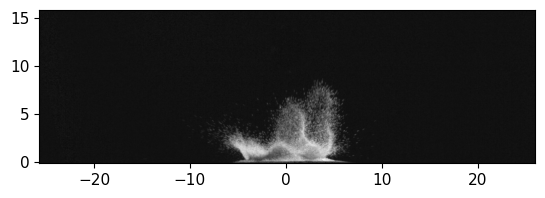

In [36]:
## Pick a frame for the background of trajectory plots 
qq = 150 # index of frame to use as background 
plt.imshow(chosen_img[qq], extent=img_extent, cmap='grey')

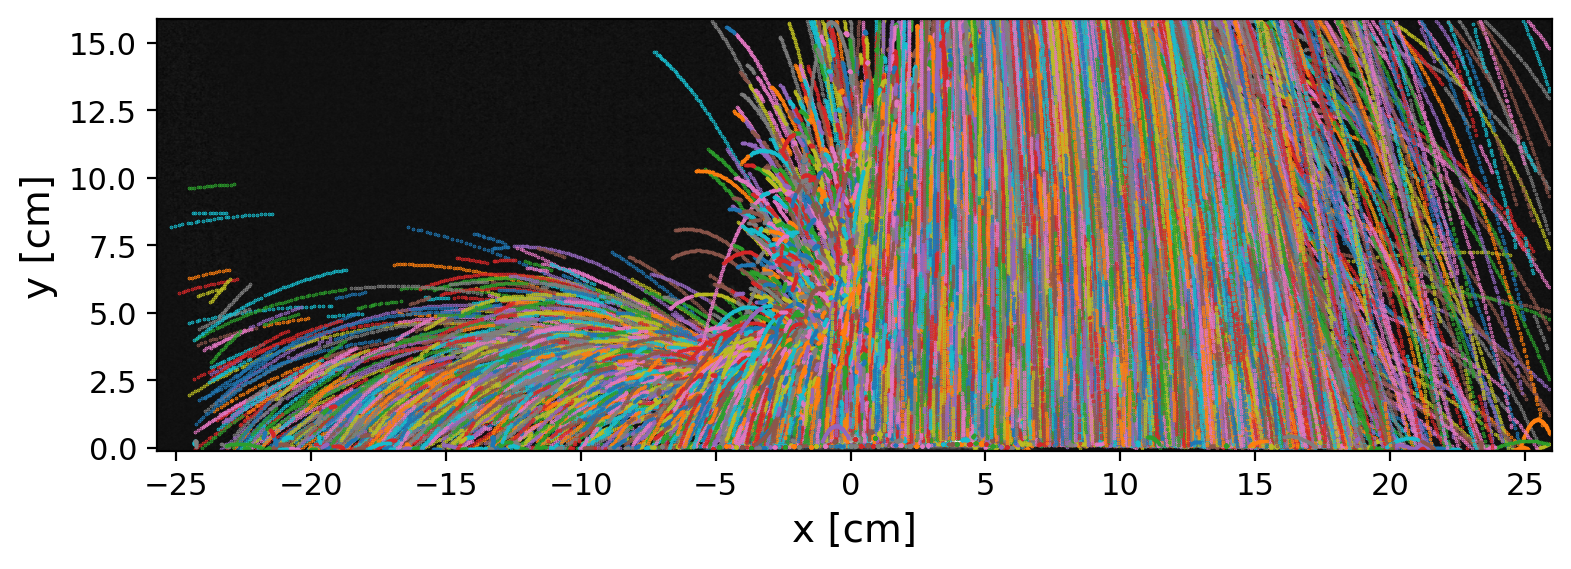

In [37]:
## Plot tracked trajectories 
fig,ax = plt.subplots(1,1,figsize=(9,4),dpi=200) # to match formatting of other figures

ax.imshow(chosen_img[qq], extent=img_extent, cmap='grey') #

track_tools.display_traj_scat(xcm, ycm, part_ids, hlabel='x [cm]', vlabel='y [cm]', \
                      coloring=None, axes=ax) 

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2.5)) # y-axis tick format 
plt.xlim(img_extent[0], img_extent[1])
plt.ylim(img_extent[2], img_extent[3]) 

ax.set_aspect('equal') 

plt.savefig(output_dir+'traj'+fname_end+'.png', dpi=200, bbox_inches='tight') 
plt.savefig(output_dir+'traj'+fname_end+'.svg')#, dpi=200, bbox_inches='tight') 


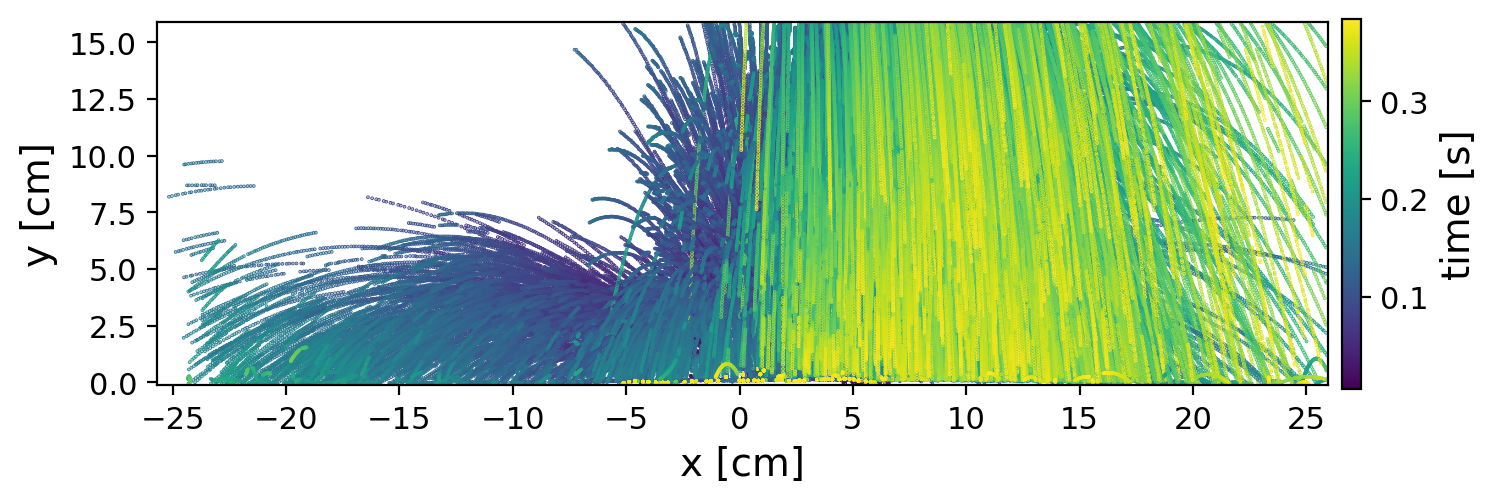

In [38]:
## Plot tracked trajectories (colored in time)
track_tools.display_traj_scat(xcm, ycm, part_ids, hlabel='x [cm]', vlabel='y [cm]', \
                      clabel='time [s]', time_arr=tsec, shrink_val=0.6, pad_val=.01, coloring=1) 

# kk=50
# track_tools.display_traj_scat(xcm[::kk], ycm[::kk], part_ids[::kk], hlabel='x [cm]', vlabel='y [cm]', \
#                       clabel='time [s]', time_arr=tsec[::kk], shrink_val=0.6, pad_val=.01, coloring=1) 

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2.5)) # y-axis tick format 
plt.gca().set_aspect('equal') 

plt.xlim(img_extent[0], img_extent[1]) 
plt.ylim(img_extent[2], img_extent[3]) 

plt.savefig(output_dir+'traj_time'+fname_end+'.png', dpi=200, bbox_inches='tight') 
plt.savefig(output_dir+'traj_time'+fname_end+'.svg')#, dpi=200, bbox_inches='tight') 

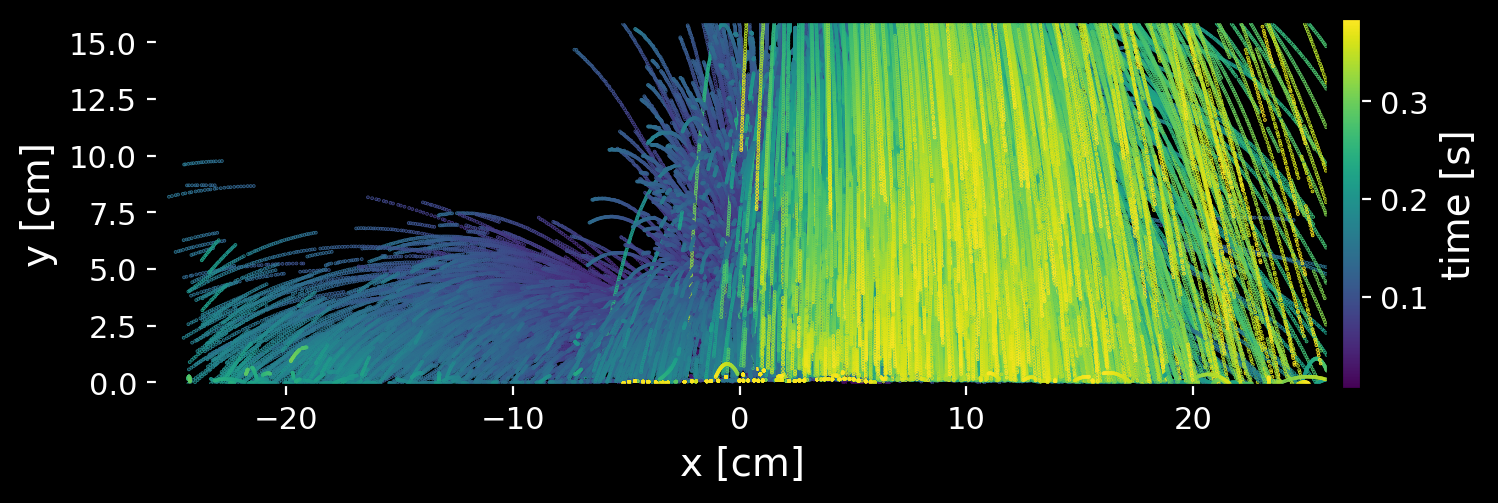

In [39]:
## Plot tracked trajectories (colored in time, dark theme) 
track_tools.display_traj_scat(xcm, ycm, part_ids, hlabel='x [cm]', vlabel='y [cm]', \
                      clabel='time [s]', time_arr=tsec, shrink_val=0.6, pad_val=.01, coloring=1, dark_mode=True) 

# kk = 50
# track_tools.display_traj_scat(xcm[::kk], ycm[::kk], part_ids[::kk], hlabel='x [cm]', vlabel='y [cm]', \
#                       clabel='time [s]', time_arr=tsec[::kk], shrink_val=0.6, pad_val=0.01, coloring=1, dark_mode=True) 

# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2.5)) # y-axis tick format 
plt.gca().set_aspect('equal') 

plt.xlim(img_extent[0], img_extent[1])
plt.ylim(img_extent[2], img_extent[3]) 

plt.savefig(output_dir+'traj_time'+fname_end+'_dark.png', dpi=200, bbox_inches='tight') 
plt.savefig(output_dir+'traj_time'+fname_end+'_dark.svg')#, dpi=200, bbox_inches='tight') 

In [40]:
# ## Position x-component 
# track_tools.display_traj_scat(tsec, xcm, part_ids, hlabel='time (s)', vlabel='x (cm)', \
#                       coloring=None)
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5)) # y-axis tick format 

In [41]:
# ## Position x-component (colored in time) 
# track_tools.display_traj_scat(tsec, xcm, part_ids, hlabel='x (cm)', vlabel='time (s)', \
#                       clabel='time (s)', time_arr=tsec, coloring=1) 
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5)) # y-axis tick format 

In [42]:
# ## Position y-component 
# track_tools.display_traj_scat(tsec, ycm, part_ids, hlabel='time (s)', vlabel='y (cm)', \
#                       coloring=None)
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2.5)) # y-axis tick format 

In [43]:
# ## Position y-component (colored in time)  
# track_tools.display_traj_scat(tsec, ycm, part_ids, hlabel='time (s)', vlabel='y (cm)', \
#                       clabel='time (s)', time_arr=tsec, coloring=1) 
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2.5)) # y-axis tick format 

In [44]:
# ## Radial distance from origin (colored in time) 
# track_tools.display_traj_scat(tsec, rcm, part_ids, hlabel='time (s)', vlabel='distance from\nimpact (cm)',\
#                         clabel='time (s)', time_arr=tsec, coloring=1)
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5)) # y-axis tick format 

In [45]:
# ## Radial distance from origin 
# track_tools.display_traj_scat(tsec, rcm, part_ids, hlabel='time (s)', vlabel='distance from\nimpact (cm)',\
#                         coloring=None)
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(5)) # y-axis tick format 
# # plt.savefig('sb_distance_origin.png', dpi=400, bbox_inches='tight') 

In [46]:
# ## Displacement from original position (colored in time) 
# track_tools.display_traj_scat(tsec, dispcm, part_ids, hlabel='time (s)', vlabel='displacement (cm)',\
#                         clabel='time (s)', time_arr=tsec, coloring=1) 
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2.5)) # y-axis tick format 

In [47]:
# ## Displacement from original position 
# track_tools.display_traj_scat(tsec, dispcm, part_ids, hlabel='time (s)', vlabel='displacement (cm)',\
#                         coloring=None) 
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2.5)) # y-axis tick format 
# # plt.savefig('sb_displacement.png', dpi=400, bbox_inches='tight') 

### Velocities
<a id='velocities'></a>

In [48]:
# ## Velocity x-component 
# track_tools.display_traj_scat(tsec, vx, part_ids, hlabel='time (s)', vlabel='vx (cm/s)', \
#                         coloring=None) 

In [49]:
# ## Velocity x-component (colored in time) 
# track_tools.display_traj_scat(tsec, vx, part_ids, hlabel='time (s)', vlabel='vx (cm/s)', \
#                       clabel='time (s)', time_arr=tsec, coloring=1) 

In [50]:
# ## Velocity y-component 
# track_tools.display_traj_scat(tsec, vy, part_ids, hlabel='time (s)', vlabel='vy (cm/s)', \
#                         coloring=None) 
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100)) # y-axis tick format 

In [51]:
# ## Velocity y-component (colored in time) 
# track_tools.display_traj_scat(tsec, vy, part_ids, hlabel='time (s)', vlabel='vy (cm/s)', \
#                       clabel='time (s)', time_arr=tsec, coloring=1) 
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100)) # y-axis tick format 

In [52]:
# ## Velocity magnitude (colored in time) 
# track_tools.display_traj_scat(tsec, vmag, part_ids, hlabel='time (s)', vlabel='|v|-side (cm/s)', \
#                       clabel='time (s)', time_arr=tsec, coloring=1) 

In [53]:
# ## Velocity magnitude 
# track_tools.display_traj_scat(tsec, vmag, part_ids, hlabel='time (s)', vlabel='|v|-side (cm/s)', \
#                       coloring=None) 
# # plt.savefig('sb_vmag.png', dpi=400, bbox_inches='tight') 

left slope: -3.500
right slope: 1.909


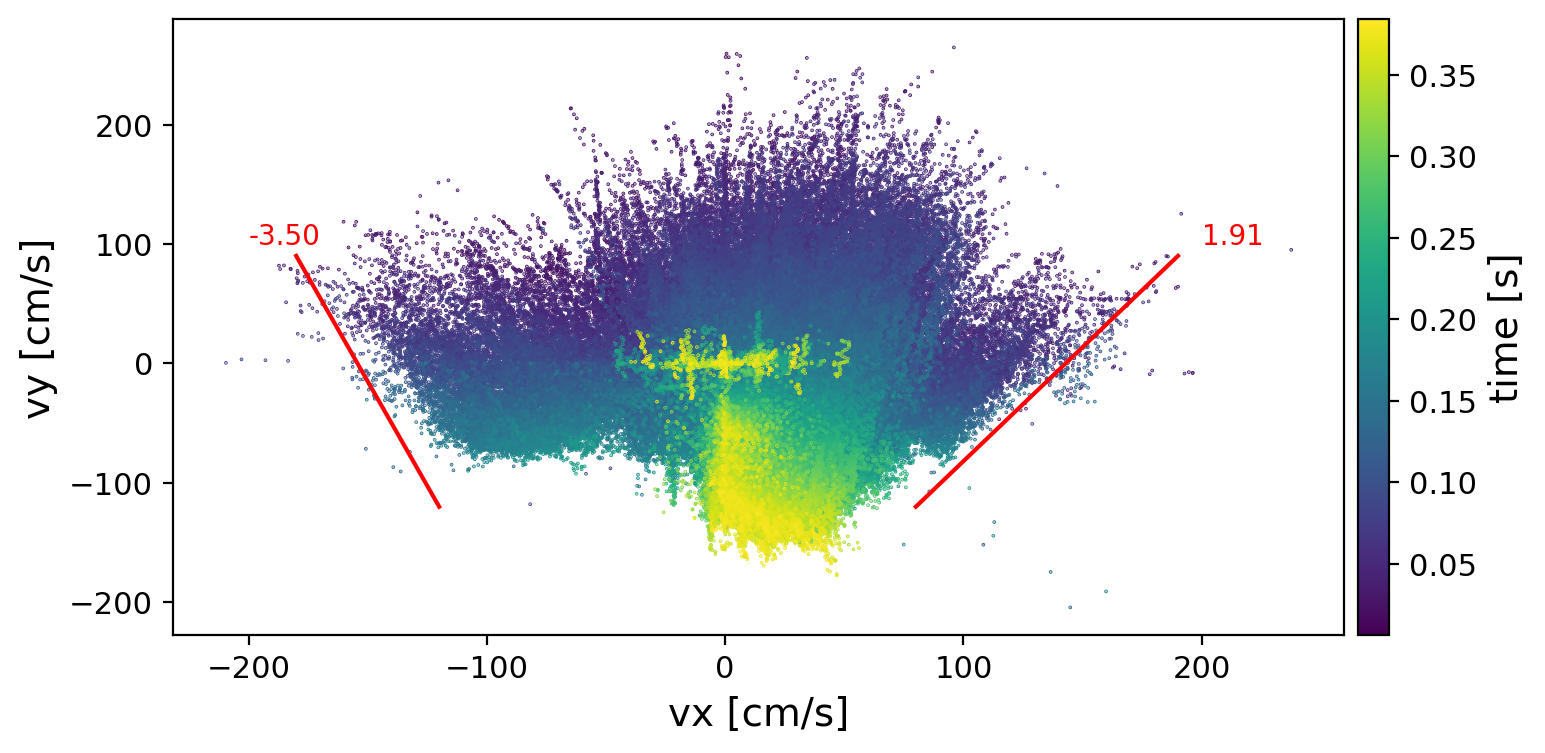

In [54]:
# ## Velocity component space (colored in time) 
# track_tools.display_traj_scat(vx, vy, part_ids, hlabel='vx [cm/s]', vlabel='vy [cm/s]', \
#                       clabel='time [s]', time_arr=tsec, pad_val=0.01, coloring=1) 
# # kk=50
# # track_tools.display_traj_scat(vx[::kk], vy[::kk], part_ids, hlabel='vx (cm/s)', vlabel='vy (cm/s)', \
# #                       clabel='time (s)', time_arr=tsec[::kk], coloring=1) 

# x11 = -180
# x12 = -120
# y11 = 90
# y12 = -120

# x21 = 190
# x22 = 80
# y21 = 90
# y22 = -120

# plt.plot([x11,x12],[y11,y12],'r')
# plt.plot([x21,x22],[y21,y22],'r')

# m1 = np.diff([y11,y12])/np.diff([x11,x12])[0]
# m2 = np.diff([y21,y22])/np.diff([x21,x22])[0]
# print('left slope: %.3f' %m1[0]) 
# print('right slope: %.3f' %m2[0]) 

# ax = plt.gca()
# ax.text(-200, 100, '%.2f' %m1[0], color='r') 
# ax.text(200, 100, '%.2f' %m2[0], color='r') 

# # plt.ylim(-150)
# # ax.set_xlim(-320,) 
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(50)) # y-axis tick format 

# plt.savefig(output_dir+'traj_velocities'+fname_end+'.png', dpi=200, bbox_inches='tight') 
# plt.savefig(output_dir+'traj_velocities'+fname_end+'.svg')#, dpi=200, bbox_inches='tight') 

left slope: -3.500
right slope: 1.909


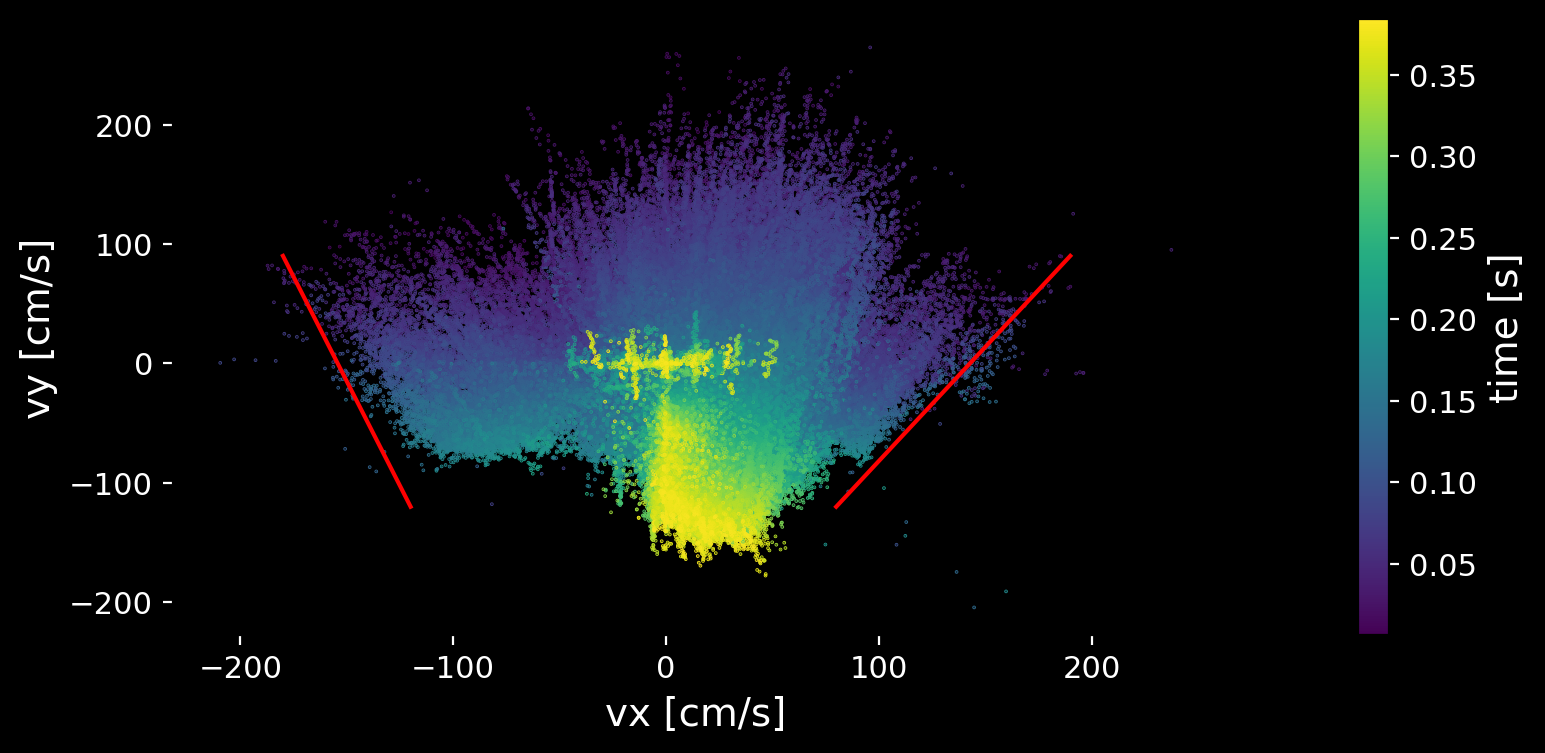

In [55]:
# ## Velocity component space (colored in time, dark version) 
# track_tools.display_traj_scat(vx, vy, part_ids, hlabel='vx [cm/s]', vlabel='vy [cm/s]', \
#                       clabel='time [s]', time_arr=tsec, pad_val=0.1, coloring=1, dark_mode=True) 
# # kk=50
# # track_tools.display_traj_scat(vx[::kk], vy[::kk], part_ids[::kk], hlabel='vx (cm/s)', vlabel='vy (cm/s)', \
# #                       clabel='time (s)', time_arr=tsec[::kk], coloring=1) 

# x11 = -180
# x12 = -120
# y11 = 90
# y12 = -120

# x21 = 190
# x22 = 80
# y21 = 90
# y22 = -120


# plt.plot([x11,x12],[y11,y12],'r')
# plt.plot([x21,x22],[y21,y22],'r')

# m1 = np.diff([y11,y12])/np.diff([x11,x12])[0]
# m2 = np.diff([y21,y22])/np.diff([x21,x22])[0]
# print('left slope: %.3f' %m1[0]) 
# print('right slope: %.3f' %m2[0]) 

# ax.text(-200, 100, '%.2f' %m1[0], color='r') 
# ax.text(200, 100, '%.2f' %m2[0], color='r') 

# # plt.ylim(-150)
# # ax.set_xlim(-320,)
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# # plt.gca().yaxis.set_major_locator(plt.MultipleLocator(50)) # y-axis tick format 

# plt.savefig(output_dir+'traj_velocities'+fname_end+'_dark.png', dpi=200, bbox_inches='tight') 
# plt.savefig(output_dir+'traj_velocities'+fname_end+'_dark.svg')#, dpi=200, bbox_inches='tight') 

### Histograms in time

(0.0, 61000.0)

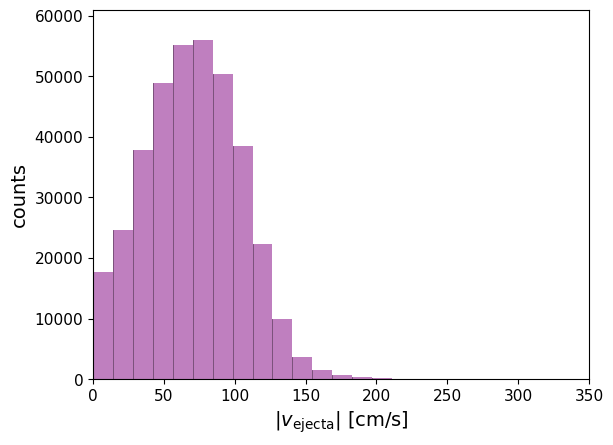

In [56]:
flattened_vel_mag = vmag[~np.isnan(vmag)]
np.shape(flattened_vel_mag)

ax = track_tools.plot_hist_w_edges(flattened_vel_mag,'purple') 
ax.set_xlabel(r'$|v_{\rm ejecta}|$ [cm/s]') 
ax.set_ylabel('counts') 

ax.set_xlim(0,350)
ax.set_ylim(0,6.1e4)

# plt.savefig(output_dir+'traj_vmag_hist'+fname_end+'.png', dpi=200, bbox_inches='tight') 
# plt.savefig(output_dir+'traj_vmag_hist'+fname_end+'.svg')#, dpi=200, bbox_inches='tight') 

In [ ]:
## Reshape velocity magnitude array 
vel_mag_time = track_tools.reshape_arr_time(len(unique_frames), np.max(npart_at_timet), vmag, time_frames) 

379
281.38470625738256 0.001515319363463167


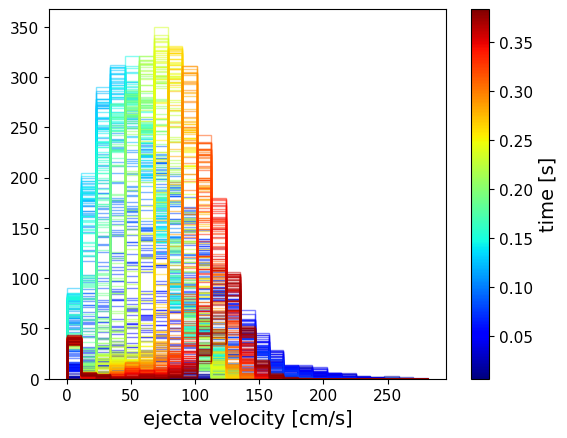

In [58]:
## Plot velocity magnitude histograms in time 
track_tools.plot_hists_in_time(tsec, vel_mag_time, 25, 'ejecta velocity [cm/s]')

data max:  281.38470625738256
data min:  0.001515319363463167
bin width:  11.255327637520763  [y-axis units]


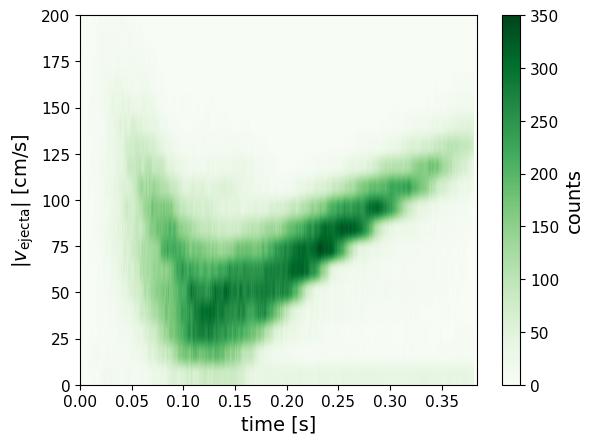

In [123]:
## Plot velocity magnitude histograms as function of time
ax_3d = track_tools.make_hists_time_3D(tsec, vel_mag_time, 25, r'$|v_{\rm ejecta}|$ [cm/s]', 'Greens')#, output_dir, 'vmag_hists_3D')#, save=True) 

# to keep axes on the same scale for comparing impacts...
xbounds = ax_3d.get_xbound()
ybounds = ax_3d.get_ybound()
# new_ylim = 521.4
new_ylim = 200
ax_3d.set_ylim(0,new_ylim)
# print(xbounds,ybounds)
# rec = mpl.patches.Rectangle((0,ybounds[1]), xbounds[1], new_ylim-ybounds[1], color=mpl.colormaps['Greens'](0))
# ax_3d.add_patch(rec)

# save figure 
plt.savefig(output_dir+'vmag_hists_3D.png', dpi=500, bbox_inches='tight')
plt.savefig(output_dir+'vmag_hists_3D.svg') # 


Text(0, 0.5, 'counts')

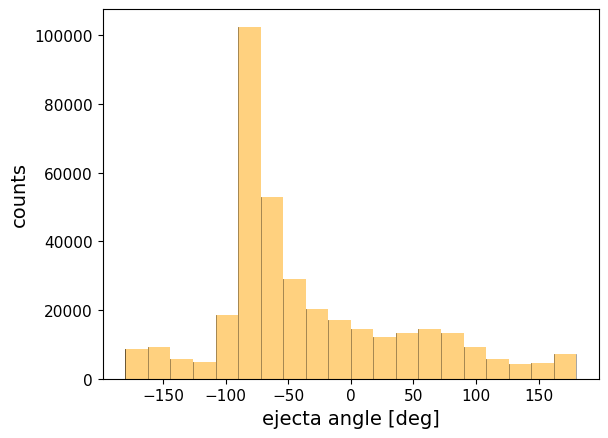

In [60]:
vel_ang_rad = np.arctan2(vy, vx)
vel_ang_deg = vel_ang_rad*180/np.pi
vel_ang_deg_flat_mask = vel_ang_deg[~np.isnan(vel_ang_deg)]

ax = track_tools.plot_hist_w_edges(vel_ang_deg_flat_mask, 'orange')
ax.set_xlabel('ejecta angle [deg]')
ax.set_ylabel('counts')

# plt.savefig(output_dir+'traj_angle'+fname_end+'.png', dpi=200, bbox_inches='tight') 
# plt.savefig(output_dir+'traj_anlge'+fname_end+'.svg')#, dpi=200, bbox_inches='tight') 

In [61]:
## Reshape velocity direction array 
vel_ang_deg_time = track_tools.reshape_arr_time(len(unique_frames), np.max(npart_at_timet), vel_ang_deg, time_frames) 

379
179.99862927711388 -179.99777456891601


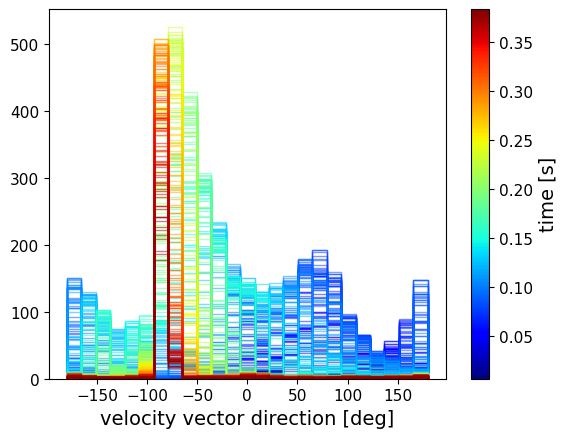

In [62]:
## Plot velocity direction histograms in time 
track_tools.plot_hists_in_time(tsec, vel_ang_deg_time, 25, 'velocity vector direction [deg]')

data max:  179.99862927711388
data min:  -179.99777456891601
bin width:  14.399856153841199  [y-axis units]


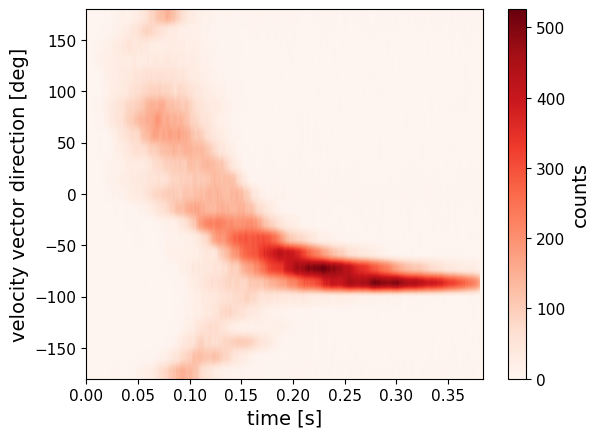

In [78]:
## Plot velocity direction histograms as function of time 
track_tools.make_hists_time_3D(tsec, vel_ang_deg_time, 25, 'velocity vector direction [deg]', 'Reds', output_dir, 'vdir_hists_3D', save=True)

### Accelerations
<a id='accelerations'></a>

In [64]:
# ## Acceleration x-component
# track_tools.display_traj_scat(tsec, accx, part_ids, hlabel='time(s)', vlabel=r'ax (cm/$\rm s^2$)', \
#                       coloring=None) 
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10000)) # y-axis tick format 

In [65]:
# ## Acceleration x-component (colored in time) 
# track_tools.display_traj_scat(tsec, accx, part_ids, hlabel='time(s)', vlabel=r'ax (cm/$\rm s^2$)', \
#                       clabel='time (s)', time_arr=tsec, coloring=1) 
# # plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5)) # x-axis tick format 
# plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10000)) # y-axis tick format 

In [66]:
# ## Acceleration y-component
# track_tools.display_traj_scat(tsec, accy, part_ids, hlabel='time(s)', vlabel=r'ay (cm/$\rm s^2$)', \
#                       coloring=None) 

In [67]:
# ## Acceleration y-component (colored in time) 
# track_tools.display_traj_scat(tsec, accy, part_ids, hlabel='time(s)', vlabel=r'ay (cm/$\rm s^2$)', \
#                       clabel='time (s)', time_arr=tsec, coloring=1) 

In [68]:
# ## Acceleration component space (colored in time) 
# track_tools.display_traj_scat(accx, accy, part_ids, hlabel=r'ax (cm/$\rm s^2$)', vlabel=r'ay (cm/$\rm s^2$)', \
#                       clabel='time (s)', time_arr=tsec, coloring=1) 
# # plt.savefig('sb_ax_ay.png', dpi=400, bbox_inches='tight')

In [69]:
# ## Acceleration component space 
# track_tools.display_traj_scat(accx, accy, part_ids, hlabel=r'ax (cm/$\rm s^2$)', vlabel=r'ay (cm/$\rm s^2$)', \
#                       coloring=None) 

In [70]:
# ## Acceleration magnitude 
# track_tools.display_traj_scat(tsec, amag, part_ids, hlabel='time(s)', vlabel=r'|a|-side (cm/$\rm s^2$)', \
#                       coloring=None) 
# # plt.savefig('sb_amag.png', dpi=400, bbox_inches='tight')

In [71]:
# ## Acceleration magnitude (colored in time) 
# track_tools.display_traj_scat(tsec, amag, part_ids, hlabel='time(s)', vlabel=r'|a|-side (cm/$\rm s^2$)', \
#                       clabel='time (s)', time_arr=tsec, coloring=1) 

In [72]:
# ## Comparing acceleration components in units of g 
# fig,ax = plt.subplots(1,1,dpi=300) 
# for ii in range(len(tsec)):
#     sc1, = ax.plot(tsec[ii], accx[ii]/1000, color='r', alpha=0.2, lw=1)
#     sc2, = ax.plot(tsec[ii], accy[ii]/1000, color='b', alpha=0.5, lw=1)

# ax.set_ylabel('acceleration component (g)') 
# ax.set_xlabel('time (s)') 
# ax.legend([sc1, sc2], ['ax', 'ay']) 

# Postcards
<a id='postcards'></a>

delf: 38.000000 frames
delt: 37.995820 ms


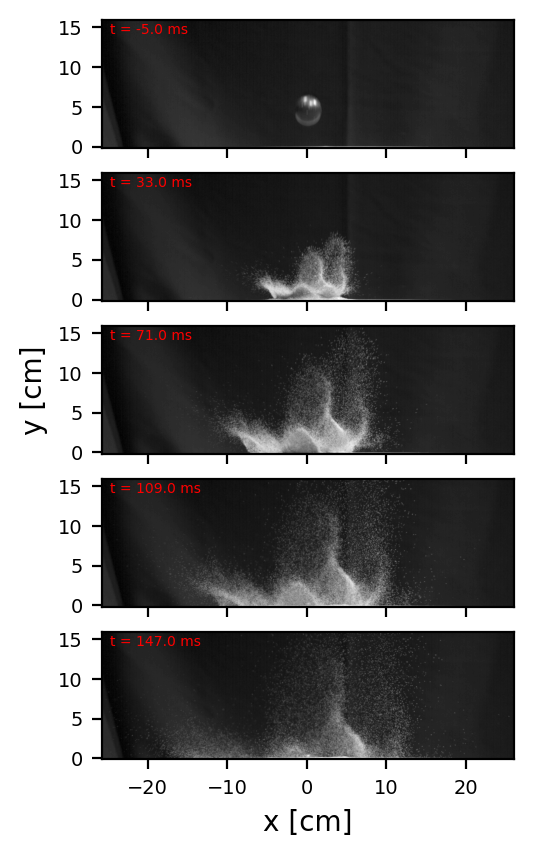

In [73]:
## Make postcard image (vertical) 
neg_frame = 5 # number of frames before time=0 to begin plotting (i.e. negative time)
nframes = 5 
increment = 10 # number of evenly spaced (in time) frames to display

# Figure setup
fig,ax = plt.subplots(nframes, 1, dpi=200, sharex=True) 

# Increment between frames to plot
delf = int((len(cframes) - t0_frame - neg_frame)/increment) 
# print(delf)

for ii in range(nframes):
    
    frame_now = t0_frame - neg_frame + ii*delf # current frame
    time_now = (frame_now - t0_frame)/framerate*1000 # current frame in milliseconds

    ax[ii].imshow(cframes[frame_now][:,:,2], 'gray', extent=img_extent) 
    ax[ii].text(0.02, 0.98, 't = %1.1f ms' %time_now, fontsize=5, color='r', horizontalalignment='left', verticalalignment='top', transform=ax[ii].transAxes)
    # ax[ii].set_xticks(fontsize=5)

    ax[ii].tick_params(axis='both', which='both', labelsize=7)
    ax[ii].yaxis.set_major_locator(plt.MultipleLocator(5)) # y-axis tick format 
    ax[ii].xaxis.set_major_locator(plt.MultipleLocator(10)) # x-axis tick format 


plt.text(-0.2, 2.9, 'y [cm]', verticalalignment='center', transform=ax[ii].transAxes, rotation =90) 
ax[-1].set_xlabel('x [cm]', fontsize=10)
plt.savefig(output_dir+'postcards_vert'+fname_end+'.png', dpi=400, bbox_inches='tight') 

# spacing between postcard images (for paper) 
print('delf: %f frames' %delf)
print('delt: %f ms' %(delf/framerate*1000) )